# Pre-activation ResNet on CIFAR10

## Configuration

Imports

In [1]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite.metrics
import ignite.contrib.handlers

Configuration

In [2]:
DATA_DIR='./data'

NUM_CLASSES = 10
NUM_WORKERS = 8
BATCH_SIZE = 32
EPOCHS = 100

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


## Data

In [4]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

In [5]:
train_dset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_transform)
test_dset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False,
                                          num_workers=NUM_WORKERS, pin_memory=True)

In [7]:
def dataset_show_image(dset, idx):
    X, Y = dset[idx]
    title = "Ground truth: {}".format(dset.classes[Y])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.imshow(np.moveaxis(X.numpy(), 0, -1))
    ax.set_title(title)
    plt.show()

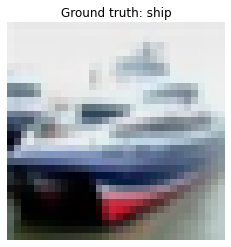

In [8]:
dataset_show_image(test_dset, 1)

## Model

In [9]:
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [10]:
class ConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        padding = (kernel_size - 1) // 2
        super().__init__(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        )

In [11]:
class BasicResidual(nn.Sequential):
    def __init__(self, in_channels, out_channels, stride=1, p_drop=0.):
        super().__init__(
            ConvBlock(in_channels, out_channels, stride=stride),
            ConvBlock(out_channels, out_channels),
            nn.Dropout(p_drop)
        )

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, p_drop=0.):
        super().__init__()
        self.shortcut = self.get_shortcut(in_channels, out_channels, stride)
        self.residual = BasicResidual(in_channels, out_channels, stride, p_drop)
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        out = self.shortcut(x) + self.gamma * self.residual(x)
        return out
    
    def get_shortcut(self, in_channels, out_channels, stride):
        if in_channels != out_channels:
            shortcut = nn.Conv2d(in_channels, out_channels, 1)
            if stride > 1:
                shortcut = nn.Sequential(nn.AvgPool2d(stride), shortcut)
        elif stride > 1:
            shortcut = nn.AvgPool2d(stride)
        else:
            shortcut = nn.Identity()
        return shortcut

In [13]:
class ResidualStack(nn.Sequential):
    def __init__(self, in_channels, repetitions, strides, p_drop=0.):
        layers = []
        out_channels = in_channels
        for rep, stride in zip(repetitions, strides):
            for _ in range(rep):
                layers.append(ResidualBlock(in_channels, out_channels, stride, p_drop))
                in_channels = out_channels
                stride = 1
            out_channels *= 2
        super().__init__(*layers)

In [14]:
class Stem(nn.Sequential):
    def __init__(self, in_channels, channel_list, stride):
        layers = [nn.Conv2d(in_channels, channel_list[0], 3, padding=1, stride=stride)]
        for in_channels, out_channels in zip(channel_list, channel_list[1:]):
            layers.append(ConvBlock(in_channels, out_channels, 3))
        super().__init__(*layers)

In [15]:
class Head(nn.Sequential):
    def __init__(self, in_channels, classes, p_drop=0.):
        super().__init__(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p_drop),
            nn.Linear(in_channels, classes)
        )

In [16]:
class ResNet(nn.Sequential):
    def __init__(self, classes, repetitions, strides=None, in_channels=3, res_p_drop=0., head_p_drop=0.):
        if strides is None: strides = [2] * (len(repetitions) + 1)
        super().__init__(
            Stem(in_channels, [32, 32, 64], strides[0]),
            ResidualStack(64, repetitions, strides[1:], res_p_drop),
            Head(64 * 2**(len(repetitions) - 1), classes, head_p_drop)
        )

In [17]:
model = ResNet(NUM_CLASSES, [2, 2, 2, 2], strides=[1, 1, 2, 2, 2], res_p_drop=0., head_p_drop=0.3)

In [18]:
model.apply(init_linear);

In [19]:
model.to(DEVICE);

In [20]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 11,203,954


## Training

### History

In [21]:
class History:
    def __init__(self):
        self.values = defaultdict(list)

    def append(self, key, value):
        self.values[key].append(value)

    def reset(self):
        for k in self.values.keys():
            self.values[k] = []

    def _begin_plot(self):
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(111)

    def _end_plot(self, ylabel):
        self.ax.set_xlabel('epoch')
        self.ax.set_ylabel(ylabel)
        plt.show()

    def _plot(self, key, line_type='-', label=None):
        if label is None: label=key
        xs = np.arange(1, len(self.values[key])+1)
        self.ax.plot(xs, self.values[key], line_type, label=label)

    def plot(self, key):
        self._begin_plot()
        self._plot(key, '-')
        self._end_plot(key)

    def plot_train_val(self, key):
        self._begin_plot()
        self._plot('train ' + key, '.-', 'train')
        self._plot('val ' + key, '.-', 'val')
        self.ax.legend()
        self._end_plot(key)

### Setup trainer

In [22]:
loss = nn.CrossEntropyLoss()

In [23]:
optimizer = optim.AdamW(model.parameters(), lr=1e-6, weight_decay=1e-2)

In [24]:
trainer = create_supervised_trainer(model, optimizer, loss, device=DEVICE)

In [25]:
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [26]:
trainer.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step());

In [27]:
ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

In [28]:
val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}

In [29]:
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE)

In [30]:
history = History()

In [31]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    history.append('train loss', train_loss)
    
    evaluator.run(test_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    history.append('val loss', val_loss)
    history.append('val acc', val_acc)
    
    print("{}/{} - train: loss {:.3f}; val: loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, val_loss, val_acc))

### Start training

In [33]:
trainer.run(train_loader, max_epochs=EPOCHS);

1/100 - train: loss 1.173; val: loss 1.053 accuracy 0.622
2/100 - train: loss 0.882; val: loss 0.845 accuracy 0.706
3/100 - train: loss 0.727; val: loss 0.695 accuracy 0.763
4/100 - train: loss 0.652; val: loss 0.651 accuracy 0.784
5/100 - train: loss 0.638; val: loss 0.587 accuracy 0.798
6/100 - train: loss 0.582; val: loss 0.589 accuracy 0.803
7/100 - train: loss 0.554; val: loss 0.586 accuracy 0.813
8/100 - train: loss 0.528; val: loss 0.577 accuracy 0.810
9/100 - train: loss 0.517; val: loss 0.506 accuracy 0.833
10/100 - train: loss 0.458; val: loss 0.590 accuracy 0.806
11/100 - train: loss 0.466; val: loss 0.478 accuracy 0.839
12/100 - train: loss 0.431; val: loss 0.521 accuracy 0.831
13/100 - train: loss 0.450; val: loss 0.443 accuracy 0.845
14/100 - train: loss 0.414; val: loss 0.416 accuracy 0.864
15/100 - train: loss 0.417; val: loss 0.531 accuracy 0.828
16/100 - train: loss 0.411; val: loss 0.499 accuracy 0.838
17/100 - train: loss 0.426; val: loss 0.462 accuracy 0.849
18/100

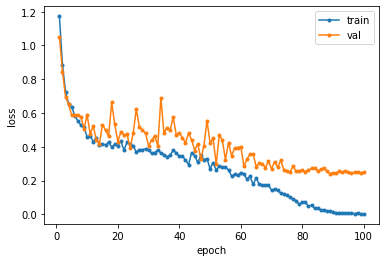

In [34]:
history.plot_train_val('loss')

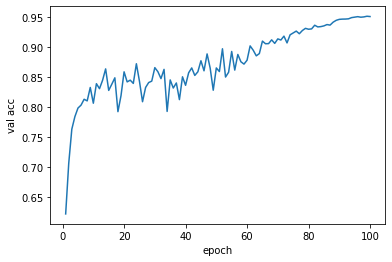

In [35]:
history.plot('val acc')